<a href="https://colab.research.google.com/github/debugk/NER_Covid19/blob/master/NER_bert_bilstm_crf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:
#install the amazing transformers package by huggingface
!pip install transformers

import transformers
import nltk
import tensorflow as tf#
import tensorflow_addons as tf_ad

from transformers import BertTokenizer, BertConfig, TFBertModel, TFBertForTokenClassification
nltk.download('punkt')

tf_model = TFBertForTokenClassification.from_pretrained('bert-base-cased', output_hidden_states=False)
#tf_model = TFBertModel.from_pretrained('bert-base-cased', output_hidden_states=False)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertForTokenClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Word embedding

In [ ]:
#==========================================================================================
def entity_match(data_tokens, data_tags, entity, i_start_sentence, i_start_token, do_D_tag=False):
    target_tokens = tokenizer.tokenize(entity['entity'])  
    target_token  = '_'.join(target_tokens)  
    len_targets   = len(target_tokens)
    
    # index of the sentence
    i_sentence = i_start_sentence

    for tokens in data_tokens[i_sentence:]:
        # index of the tokens in a sentence
        if i_sentence == i_start_sentence: 
            # start search from position i_start_token
            i = i_start_token
        else:
            i = 0

        while i < len(tokens):
            if (i+len_targets) > len(tokens): break 

            match_token = '_'.join(tokens[i:i+len_targets])

            if match_token ==  target_token:
                tag = 'DB-' if do_D_tag else 'B-'
                data_tags[i_sentence][i] = tag + entity['type'] # python will update the list like reference in c++

                for j in range(1, len_targets):
                    if i+j >= len(data_tags[i_sentence]): continue 
                     
                    sub_tag = 'DI-' if do_D_tag else 'I-'
                    data_tags[i_sentence][i+j] = sub_tag + entity['type']

                # update the position
                i += len_targets 

                return (True, i_sentence, i) # is matched, index of current sentence, index of current token
            else:
                i += 1

        # move to next sentence        
        i_sentence += 1

    # Cannot find the entity from the data_tokens[i_start_sentence][i_start_token:] and data_tokens[i_start_sentence+1:]
    return (False, 0, 0)

#==========================================================================================
def prepare_tokentags(data, max_length = 150, fdebug=False):
    data_tags   = []
    data_tokens = []

    sentences = nltk.tokenize.sent_tokenize(data['text'])
    entities  = sorted(data['entities'], key=lambda entity: entity['start']) # sort by the entity start point
        
    for sentence in sentences:
        # Add the special tokens.
        sentence = "[CLS] " + sentence + "[SEP]" 
        tokens = tokenizer.tokenize(sentence)
        sentence_tags = ['O']*max_length

        if len(tokens) < max_length:
            tokens += ["[PAD]"]*(max_length - len(tokens))
        else:
            # remove the tokens beyond the max_length
            tokens = tokens[:max_length]

        data_tags   += [sentence_tags]  
        data_tokens += [tokens]

    #
    # process entities 
    #
    unmatched_entities = []
    i_cur_sentence   = 0
    i_cur_token      = 0

    # up to now, the entry with max entry['end'] 
    max_endpoint     = 0 # help to aviod duplicated tag
    max_tokenlength  = 0

    for entity in entities:
        do_D_tag = False
        # check whether the new entity is inside the privious entity
        if entity['start'] < max_endpoint:  
            do_D_tag = True
            i_cur_token -= max_tokenlength # back to the privious entity start point
        else: 
            max_endpoint = entity['end']
            max_tokenlength = len(tokenizer.tokenize(entity['entity']))

        is_matched, i_matched_sentence, i_matched_token = entity_match(data_tokens, data_tags, entity, i_cur_sentence, i_cur_token, do_D_tag)

        if is_matched:
            if do_D_tag:
                i_cur_token += max_tokenlength
            else:
                # save the current "good" position, in case of we meet the bad entity, we can back to "good" position, do search again.
                i_cur_sentence = i_matched_sentence 
                i_cur_token    = i_matched_token
        else:
            unmatched_entities += [entity]
            
    if fdebug:
        for tokens, sentence_tags in zip(data_tokens, data_tags):
            for token, tag in zip(tokens, sentence_tags):
                print("{}\t{}".format(tag, token))
 
    if unmatched_entities: 
        print(sentences)
        print("unmatched tags: ", unmatched_entities)

    return (data_tokens, data_tags)


#==========================================================================================
def prepare_ids_masks(datas, max_length = 150, fdebug=False):
    sentences = []
    
    for data in datas:
        sentences += nltk.tokenize.sent_tokenize(data['text'])
    
    # it will extrat the same token as "tokenizer.encode(sentence)" or "tokenizer.tokenize(sentence); tokenizer.convert_tokens_to_ids()"
    tf_inputs = tokenizer(sentences, padding=True, max_length=max_length, return_attention_mask=True, return_tensors="tf", truncation=True) 

    return tf_inputs# tensorflow tensor

#==========================================================================================
def prepare_embedding(datas, max_length = 150, fdebug=False):
    sentences = []
    
    for data in datas:
        sentences += nltk.tokenize.sent_tokenize(data['text'])
    
    # it will extrat the same token as "tokenizer.encode(sentence)" or "tokenizer.tokenize(sentence); tokenizer.convert_tokens_to_ids()"
    tf_inputs = tokenizer.encode_plus(sentences, pad_to_max_length=True, return_attention_mask=True, return_tensors="tf" ) 

    if fdebug:
        print(tf_inputs)

    tf_outputs = tf_model(tf_inputs)

    # use the second-to-last layer for embedding.   
    last_hidden_states = tf_outputs[0]

    return last_hidden_states # tensorflow tensor

# Read training file

In [ ]:
import json
input_dir = "/content/gdrive/My Drive/Covid19_data/"

f = open(input_dir+'new_train.json','r')
datas = []
for line in f:
  datas.append(json.loads(line))

In [ ]:
train_tags = []

for data in datas:
    _, cur_tags = prepare_tokentags(data)
    
    train_tags += cur_tags

['Safety and efficacy of intravenous bimagrumab in inclusion body myositis (RESILIENT): a randomised, double-blind, placebo-controlled phase 2b trial\tBimagrumab showed a good safety profile, relative to placebo, in individuals with inclusion body myositis but did not improve 6MWD.', 'The strengths of our study are that, to the best of our knowledge, it is the largest randomised controlled trial done in people with inclusion body myositis, and it provides important natural history data over 12 months.']
unmatched tags:  [{'entity': 'pyrimidine nucleoside derivatives', 'type': 'ChemicalCompound', 'start': 273, 'end': 306}]
['Irinotecan–temozolomide with temsirolimus or dinutuximab in children with refractory or relapsed neuroblastoma (COG ANBL1221): an open-label, randomised, phase 2 trial\tIrinotecan–temozolomide–dinutuximab met protocol-defined criteria for selection as the combination meriting further study whereas irinotecan–temozolomide–temsirolimus did not.', 'Irinotecan–temozolom

In [ ]:
# convert the label to int, refers to different categories
tag_values = []
pre_tags = ['Virus', 'Organization', 'Drug', 'Chemical', 'Disease', 'Gene', 'ChemicalCompound', 'Phenotype']

for tag in pre_tags:
    tag_values += ['B-' + tag]
    tag_values += ['I-' + tag]
    tag_values += ['DB-'+ tag]
    tag_values += ['DI-'+ tag]

tag_values += ['O']

tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_values

['B-Virus',
 'I-Virus',
 'DB-Virus',
 'DI-Virus',
 'B-Organization',
 'I-Organization',
 'DB-Organization',
 'DI-Organization',
 'B-Drug',
 'I-Drug',
 'DB-Drug',
 'DI-Drug',
 'B-Chemical',
 'I-Chemical',
 'DB-Chemical',
 'DI-Chemical',
 'B-Disease',
 'I-Disease',
 'DB-Disease',
 'DI-Disease',
 'B-Gene',
 'I-Gene',
 'DB-Gene',
 'DI-Gene',
 'B-ChemicalCompound',
 'I-ChemicalCompound',
 'DB-ChemicalCompound',
 'DI-ChemicalCompound',
 'B-Phenotype',
 'I-Phenotype',
 'DB-Phenotype',
 'DI-Phenotype',
 'O']

In [ ]:
train_tags_id = [[tag2idx.get(l) for l in lab] for lab in train_tags]

In [ ]:
bert_inputs = prepare_ids_masks(datas)

train_ids   = bert_inputs['input_ids'] 
train_masks = bert_inputs['attention_mask']

# Taining 

In [ ]:
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, TimeDistributed


In [ ]:
from sklearn.model_selection import train_test_split

labels = keras.utils.to_categorical(train_tags_id) 

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_ids.numpy(), labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_masks.numpy(), labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [ ]:
BATCH_SIZE = 16
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [ ]:
import tensorflow.keras as keras
#
# define model
#
class NerModel(tf.keras.Model):
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.mode = mode 

        self.bert = bert
        self.bert.trainable = False    

        self.biLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True), merge_mode='concat')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.tdense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes, activation="softmax"))    
             
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
       bert_outputs = self.bert(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                head_mask=head_mask)
       
       outputs = bert_outputs[0] #only use the last layer weight as embeddin
       outputs = self.dropout(outputs)
       outputs = self.biLSTM(outputs)
       outputs = self.tdense(outputs)

       return outputs

#==========================================================================================
class NerModel_CRF(tf.keras.Model):
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.bert.trainable = False    

        self.biLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True), merge_mode='concat')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.tdense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes, activation="softmax"))    
        
        self.addloss = tf.Variable(0, name="loss", trainable=False)

        self.transition_params = tf.Variable(tf.random.uniform(shape=(num_classes, num_classes)), name="transition", trainable=True)
      
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
       bert_outputs = self.bert(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                head_mask=head_mask)
       
       outputs = bert_outputs[0] #only use the last layer weight as embeddin
       outputs = self.dropout(outputs)
       outputs = self.biLSTM(outputs)
       outputs = self.tdense(outputs)

       if labels is not None:
           text_lens = tf.math.reduce_sum(attention_mask, axis=-1)
           label_sequences = tf.cast(tf.math.argmax(labels, -1), dtype=tf.int32)#    

           log_likelihood, self.transition_params = tf_ad.text.crf_log_likelihood(outputs,
                                                                                  label_sequences,
                                                                                  text_lens,
                                                                                  transition_params=self.transition_params)
           return outputs, log_likelihood

       return outputs



In [ ]:
#
# helper class:
#  -- to solve the problem when we create the tf.Variable not for the first time with `@tf.function`
#  -- https://github.com/tensorflow/tensorflow/issues/27120
#

class TrainModelHelper:
    def __init__(self, model):
        self.model = model

        # Loss
        self.loss_object = tf.keras.losses.CategoricalCrossentropy()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.validation_loss = tf.keras.metrics.Mean(name='test_loss')      
  
        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name="Adam")
  
        # Metrics
        self.train_acc_metrics = tf.keras.metrics.CategoricalAccuracy()
        self.validation_acc_metrics = tf.keras.metrics.CategoricalAccuracy()

    @tf.function
    def train_step(self, token_ids, masks, labels):
        with tf.GradientTape() as tape:
            predictions = self.model(token_ids, attention_mask=masks)
            loss = self.loss_object(labels, predictions)

        gradients = tape.gradient(loss, self.model.trainable_variables)
    
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))        

        self.train_loss(loss)
        self.train_acc_metrics.update_state(labels, predictions)

        
    @tf.function
    def validation_step(self, token_ids, masks, labels):
        labels = tf.dtypes.cast(labels, tf.float32)    

        predictions = self.model(token_ids, attention_mask=masks, training=False)

        v_loss = self.loss_object(labels, predictions)

        self.validation_loss(v_loss)
        self.validation_acc_metrics.update_state(labels, predictions)

#==========================================================================================
class TrainModelHelper_CRF:
    def __init__(self, model):
        self.model = model

        # Loss
        self.loss_object = tf.keras.losses.CategoricalCrossentropy()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.validation_loss = tf.keras.metrics.Mean(name='test_loss')      
  
        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name="Adam")
  
        # Metrics
        self.train_acc_metrics = tf.keras.metrics.CategoricalAccuracy()
        self.validation_acc_metrics = tf.keras.metrics.CategoricalAccuracy()

    @tf.function
    def train_step(self, token_ids, masks, labels):
        with tf.GradientTape() as tape:
            predictions, log_likelihood = self.model(token_ids, attention_mask=masks, labels=labels)
            #loss = - tf.reduce_mean(log_likelihood)
            loss = self.loss_object(labels, predictions) - tf.reduce_mean(log_likelihood)

        gradients = tape.gradient(loss, self.model.trainable_variables)
    
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))        

        self.train_loss(loss)
        self.train_acc_metrics.update_state(labels, predictions)

        
    @tf.function
    def validation_step(self, token_ids, masks, labels):
        labels = tf.dtypes.cast(labels, tf.float32)    

        predictions, log_likelihood = self.model(token_ids, attention_mask=masks, labels=labels, training=False)
        #v_loss = - tf.reduce_mean(log_likelihood)
        v_loss = self.loss_object(labels, predictions) - tf.reduce_mean(log_likelihood)

        self.validation_loss(v_loss)
        self.validation_acc_metrics.update_state(labels, predictions)


In [ ]:
import time
from tqdm.notebook import tqdm
                                             
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs, doCRF=False):
    if doCRF:
        model_helper = TrainModelHelper_CRF(model)
    else:
        model_helper = TrainModelHelper(model)

    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            model_helper.train_step(token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {model_helper.train_loss.result()}')
            
            if i > train_steps_per_epoch:
                break
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            if i > val_steps_per_epoch:
                break
            
            model_helper.validation_step(token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {model_helper.validation_loss.result()}, Time: {time.time()-start}\n')

        
        print(f"roc_acc {model_helper.validation_acc_metrics.result()}")
        model_helper.validation_acc_metrics.reset_states()

        print('\n')
     

In [ ]:
len(train_dataset)

2018

In [ ]:
train_size = len(train_dataset)
validation_size = len(validation_dataset)

model = NerModel_CRF(tf_model, len(tag_values))
# !!! stop train the bert model
model.bert.trainable = False

#train(model, train_dataset, validation_dataset, train_steps_per_epoch=1, val_steps_per_epoch=1, epochs=NR_EPOCHS, doCRF=True)
train(model, train_dataset, validation_dataset, train_steps_per_epoch=train_size, val_steps_per_epoch=validation_size, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================



Train Step: 0, Loss: 3.515282392501831

Train Step: 1000, Loss: 0.39389023184776306

Train Step: 2000, Loss: 0.31969618797302246





Epoch 1, Validation Loss: 0.2451191395521164, Time: 429.525146484375

roc_acc 0.9534410834312439




In [ ]:
train(model, train_dataset, validation_dataset, train_steps_per_epoch=train_size, val_steps_per_epoch=validation_size, epochs=8)

================================================== EPOCH 0 ==================================================



Train Step: 0, Loss: 0.20184512436389923

Train Step: 1000, Loss: 0.23512481153011322

Train Step: 2000, Loss: 0.23315227031707764





Epoch 1, Validation Loss: 0.2326129972934723, Time: 414.85043597221375

roc_acc 0.9534410834312439


================================================== EPOCH 1 ==================================================



Train Step: 0, Loss: 0.23348523676395416

Train Step: 1000, Loss: 0.23018477857112885

Train Step: 2000, Loss: 0.227763831615448





Epoch 2, Validation Loss: 0.22702686488628387, Time: 418.0208055973053

roc_acc 0.9534429311752319


================================================== EPOCH 2 ==================================================



Train Step: 0, Loss: 0.22778312861919403

Train Step: 1000, Loss: 0.22533559799194336

Train Step: 2000, Loss: 0.22368216514587402





Epoch 3, Validation Loss: 0.2235032171010971, Time: 417.793568611145

roc_acc 0.9534429311752319


================================================== EPOCH 3 ==================================================



Train Step: 0, Loss: 0.22363051772117615

Train Step: 1000, Loss: 0.2216513305902481

Train Step: 2000, Loss: 0.22045999765396118





Epoch 4, Validation Loss: 0.221694216132164, Time: 418.1368148326874

roc_acc 0.9534429311752319


================================================== EPOCH 4 ==================================================



Train Step: 0, Loss: 0.22049956023693085

Train Step: 1000, Loss: 0.21911995112895966

Train Step: 2000, Loss: 0.2180202752351761





Epoch 5, Validation Loss: 0.2194848656654358, Time: 417.7445170879364

roc_acc 0.9534466862678528


================================================== EPOCH 5 ==================================================



Train Step: 0, Loss: 0.21805156767368317

Train Step: 1000, Loss: 0.21686145663261414

Train Step: 2000, Loss: 0.2161179482936859





Epoch 6, Validation Loss: 0.21769119799137115, Time: 417.56477451324463

roc_acc 0.9534578323364258


================================================== EPOCH 6 ==================================================



Train Step: 0, Loss: 0.21608375012874603

Train Step: 1000, Loss: 0.21508169174194336

Train Step: 2000, Loss: 0.21436651051044464





Epoch 7, Validation Loss: 0.21610568463802338, Time: 416.63106203079224

roc_acc 0.9534243941307068


================================================== EPOCH 7 ==================================================



Train Step: 0, Loss: 0.21434909105300903

Train Step: 1000, Loss: 0.21340776979923248

Train Step: 2000, Loss: 0.2128099799156189





Epoch 8, Validation Loss: 0.21466432511806488, Time: 418.11083245277405

roc_acc 0.9534633755683899




In [ ]:
train(model, train_dataset, validation_dataset, train_steps_per_epoch=train_size, val_steps_per_epoch=validation_size, epochs=2)


================================================== EPOCH 0 ==================================================



Train Step: 0, Loss: 0.13152413070201874

Train Step: 1000, Loss: 0.05979982390999794

Train Step: 2000, Loss: 0.059678301215171814





Epoch 1, Validation Loss: 0.06367290765047073, Time: 403.5517361164093

roc_acc 0.9803195595741272


================================================== EPOCH 1 ==================================================



Train Step: 0, Loss: 0.05963175371289253

Train Step: 1000, Loss: 0.05870158225297928

Train Step: 2000, Loss: 0.057975754141807556





Epoch 2, Validation Loss: 0.06297530233860016, Time: 397.72616481781006

roc_acc 0.9806187152862549




In [ ]:
train(model, train_dataset, validation_dataset, train_steps_per_epoch=train_size, val_steps_per_epoch=validation_size, epochs=2)


================================================== EPOCH 0 ==================================================



Train Step: 0, Loss: 0.06579966098070145

Train Step: 1000, Loss: 0.0536881722509861

Train Step: 2000, Loss: 0.05350245162844658





Epoch 1, Validation Loss: 0.06171770766377449, Time: 389.98867106437683

roc_acc 0.9809828996658325


================================================== EPOCH 1 ==================================================



Train Step: 0, Loss: 0.0535367876291275

Train Step: 1000, Loss: 0.05258593335747719

Train Step: 2000, Loss: 0.05239502713084221





Epoch 2, Validation Loss: 0.061516862362623215, Time: 394.61509108543396

roc_acc 0.9809234738349915




In [ ]:
model.transition_params

<tf.Variable 'transition:0' shape=(33, 33) dtype=float32, numpy=
array([[0.7978374 , 0.06214654, 0.11279523, ..., 0.81418025, 0.9830977 ,
        0.9974364 ],
       [0.9789436 , 0.07709694, 0.6931385 , ..., 0.27008379, 0.16562736,
        0.9542347 ],
       [0.7280656 , 0.9966525 , 0.06521153, ..., 0.2977301 , 0.21562672,
        0.82671404],
       ...,
       [0.21081507, 0.2602371 , 0.75185335, ..., 0.64328694, 0.65272224,
        0.729246  ],
       [0.66661334, 0.06525838, 0.62912786, ..., 0.4414041 , 0.90899694,
        0.22691107],
       [0.6169565 , 0.41175604, 0.9796387 , ..., 0.7067239 , 0.9776068 ,
        0.12774849]], dtype=float32)>

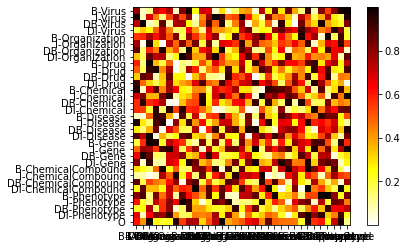

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_yticks(range(len(tag_values)))
ax.set_yticklabels(tag_values)
ax.set_xticks(range(len(tag_values)))
ax.set_xticklabels(tag_values)

im = ax.imshow(model.transition_params.numpy(), cmap=plt.cm.hot_r)

plt.colorbar(im)
plt.show()



In [ ]:
model.summary()

Model: "ner_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model (TFBertModel)  multiple                  108310272 
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  126240    
_________________________________________________________________
time_distributed_1 (TimeDist multiple                  1353      
Total params: 108,437,865
Trainable params: 127,593
Non-trainable params: 108,310,272
_________________________________________________________________


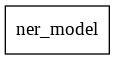

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
train_ids[:10]

<tf.Tensor: shape=(10, 150), dtype=int32, numpy=
array([[  101,  9218,  1105, ...,     0,     0,     0],
       [  101,  1109, 23347, ...,     0,     0,     0],
       [  101,  3225,  2699, ...,     0,     0,     0],
       ...,
       [  101,   157, 19366, ...,     0,     0,     0],
       [  101,  1438,   117, ...,     0,     0,     0],
       [  101,  1706,  4134, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
for i, (token_ids, masks, labels) in enumerate(train_dataset):
  print(token_ids.numpy)
  print(masks.numpy)
  print(labels.numpy())
  print(labels.numpy().argmax(axis=2))

  print("="*30)
  print((token_ids.numpy()[0] == 0).sum())
  print((masks.numpy()[0] == 0).sum())
  
  print("="*30)
  print(labels.numpy().argmax(axis=2)[3])

  tem_out = model(token_ids, masks)


  print(tem_out.numpy().argmax(axis=2)[3])
  break

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(8, 150), dtype=int32, numpy=
array([[  101,  1188,  1110, ...,     0,     0,     0],
       [  101,   153, 10132, ...,     0,     0,     0],
       [  101,  3973,  1104, ...,     0,     0,     0],
       ...,
       [  101,  1109, 12645, ...,     0,     0,     0],
       [  101,  4108,  1665, ...,     0,     0,     0],
       [  101,  7469,  1658, ...,     0,     0,     0]], dtype=int32)>>
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(8, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>>
[[[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.

In [ ]:
tem = model.predict([train_ids[:50], train_masks[:50]])

In [ ]:
model(train_ids[:10], train_masks[:10])[0][10:14]

<tf.Tensor: shape=(4, 33), dtype=float32, numpy=
array([[9.29225422e-03, 1.23211714e-02, 2.26467073e-05, 4.49517611e-05,
        2.55478523e-03, 2.68520089e-03, 1.84889120e-06, 2.75906768e-06,
        1.42638180e-02, 4.68934216e-02, 7.45146172e-05, 1.32822737e-04,
        2.27832468e-03, 4.70873900e-03, 5.69382382e-06, 5.33699540e-06,
        2.92770099e-02, 6.77880198e-02, 2.16412023e-04, 2.62671441e-04,
        7.41990702e-03, 1.84390433e-02, 1.89607963e-05, 4.32380548e-05,
        6.28628331e-05, 5.79373736e-05, 1.03813633e-08, 8.00451883e-09,
        2.19285907e-03, 2.37280689e-03, 5.00597780e-05, 3.21760417e-05,
        7.76477635e-01],
       [2.26883572e-02, 2.21550744e-02, 4.64843579e-05, 9.42861225e-05,
        3.02637625e-03, 3.36178904e-03, 2.85360420e-06, 5.91287289e-06,
        1.26226610e-02, 5.80939427e-02, 9.19934973e-05, 1.89879225e-04,
        2.86292145e-03, 6.36666641e-03, 9.33240426e-06, 1.12670814e-05,
        5.51277958e-02, 1.51213974e-01, 5.09511097e-04, 6.5626

In [ ]:
tem[0][10:14]

array([[9.29227471e-03, 1.23211574e-02, 2.26467037e-05, 4.49517502e-05,
        2.55478709e-03, 2.68520042e-03, 1.84889086e-06, 2.75907223e-06,
        1.42638329e-02, 4.68934327e-02, 7.45146754e-05, 1.32822708e-04,
        2.27832538e-03, 4.70873807e-03, 5.69382291e-06, 5.33699995e-06,
        2.92770732e-02, 6.77880868e-02, 2.16411980e-04, 2.62671529e-04,
        7.41990842e-03, 1.84390265e-02, 1.89607763e-05, 4.32380912e-05,
        6.28629423e-05, 5.79373627e-05, 1.03813615e-08, 8.00451794e-09,
        2.19286187e-03, 2.37280992e-03, 5.00598580e-05, 3.21760963e-05,
        7.76477516e-01],
       [2.26884130e-02, 2.21550763e-02, 4.64844125e-05, 9.42862316e-05,
        3.02637811e-03, 3.36179091e-03, 2.85360761e-06, 5.91288517e-06,
        1.26226703e-02, 5.80939800e-02, 9.19934173e-05, 1.89879429e-04,
        2.86292331e-03, 6.36667060e-03, 9.33241427e-06, 1.12670932e-05,
        5.51278889e-02, 1.51214227e-01, 5.09511912e-04, 6.56262157e-04,
        8.71849991e-03, 2.52137240e-02,

In [ ]:
tem[0][10:14].reshape(-1)

array([9.29227471e-03, 1.23211574e-02, 2.26467037e-05, 4.49517502e-05,
       2.55478709e-03, 2.68520042e-03, 1.84889086e-06, 2.75907223e-06,
       1.42638329e-02, 4.68934327e-02, 7.45146754e-05, 1.32822708e-04,
       2.27832538e-03, 4.70873807e-03, 5.69382291e-06, 5.33699995e-06,
       2.92770732e-02, 6.77880868e-02, 2.16411980e-04, 2.62671529e-04,
       7.41990842e-03, 1.84390265e-02, 1.89607763e-05, 4.32380912e-05,
       6.28629423e-05, 5.79373627e-05, 1.03813615e-08, 8.00451794e-09,
       2.19286187e-03, 2.37280992e-03, 5.00598580e-05, 3.21760963e-05,
       7.76477516e-01, 2.26884130e-02, 2.21550763e-02, 4.64844125e-05,
       9.42862316e-05, 3.02637811e-03, 3.36179091e-03, 2.85360761e-06,
       5.91288517e-06, 1.26226703e-02, 5.80939800e-02, 9.19934173e-05,
       1.89879429e-04, 2.86292331e-03, 6.36667060e-03, 9.33241427e-06,
       1.12670932e-05, 5.51278889e-02, 1.51214227e-01, 5.09511912e-04,
       6.56262157e-04, 8.71849991e-03, 2.52137240e-02, 4.18532727e-05,
      

In [ ]:
count = 0
for truth, pred in zip(np.reshape(train_tags_id, -1), tem.argmax(axis=2).reshape(-1)):
    if pred != 32:
        print("{}\t{}".format(truth, pred))

        if truth == pred:
          count +=1

print(count)

NameError: ignored

# Evaluation

In [ ]:
f_eval = open(input_dir+'new_train.json','r')
eval_datas = []
for line in f_eval:
  eval_datas.append(json.loads(line))

In [ ]:
eval_bert_inputs = prepare_ids_masks(eval_datas)

eval_ids   = [eval_bert_inputs['input_ids']]
eval_masks = [eval_bert_inputs['attention_mask']]

In [ ]:
crf_model = model

In [ ]:
%%time
out_score = crf_model.predict([eval_ids[0], eval_masks[0]])

CPU times: user 1min 19s, sys: 18.4 s, total: 1min 37s
Wall time: 6min 24s


In [ ]:
import h5py
input_dir = "/content/gdrive/My Drive/Covid19_data/"

out_eval_file = h5py.File(input_dir+'bert_bilstm_crf_eval_crfloss.h5', 'w')
out_eval_file['score'] = out_score
out_eval_file.close()

NameError: ignored

In [ ]:
tem2 = h5py.File(input_dir+'bert_bilstm_crf_eval.h5', 'r')